In [0]:
import numpy as np
from PIL import Image
import os
import string
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from torchvision import models, datasets, transforms

* Skip these lines if not using Google Colab

In [43]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
!mkdir project
!cp -r 'drive/My Drive/Colab Notebooks/image-captioning/captioning.py' project
!cp -r 'drive/My Drive/Colab Notebooks/image-captioning/dataset.py' project
!cp -r 'drive/My Drive/Colab Notebooks/image-captioning/model.py' project
!cp -r 'drive/My Drive/Colab Notebooks/image-captioning/utils.py' project
!cp -r 'drive/My Drive/Colab Notebooks/image-captioning/datasets' project
# !cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/embedding' project

In [2]:
cd project

/content/project


* Import all necessary functions

In [0]:
from utils import get_captions, get_embedding_dict, get_embedding_matrix, get_images_list, get_padded_captions, encode_captions
from dataset import CaptioningDataset
from model import Decoder, Encoder
from captioning import Captioning

In [0]:
from zipfile import ZipFile
with ZipFile('datasets/Flickr8k_Dataset.zip') as zipObj:
    zipObj.extractall('datasets')
with ZipFile('datasets/Flickr8k_text.zip') as zipObj:
    zipObj.extractall('datasets')

* Get GloVe embedding vectors, skip this lines if you prefer not to use pretrained embedding weights

In [0]:
# embedding_dict = get_embedding_dict('embedding/glove.6B.100d.txt')

## Loading data files
* Get list of training images by running `get_images_list()` function

In [5]:
train_images = get_images_list('datasets/Flickr_8k.trainImages.txt')
train_images[:3]

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg']

* Get dictionary of training captions mapping to each images, using `get_captions()`

In [6]:
train_captions = get_captions('datasets/Flickr8k.token.txt', train_images)
train_captions['2513260012_03d33305cf.jpg']

['<START> a black dog is running after a white dog in the snow  <END>',
 '<START> black dog chasing brown dog through snow <END>',
 '<START> two dogs chase each other across the snowy ground  <END>',
 '<START> two dogs play together in the snow  <END>',
 '<START> two dogs running through a low lying body of water  <END>']

* Get padded version of captions and return maximum training captions' length, using `get_padded_captions()`

In [7]:
train_captions_padded, max_length = get_padded_captions(train_captions)
train_captions_padded['2513260012_03d33305cf.jpg']

['<START> a black dog is running after a white dog in the snow  <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> black dog chasing brown dog through snow <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> two dogs chase each other across the snowy ground  <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> two dogs play together in the snow  <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> two dogs running through a low lying body of water  <END> <PAD> <PAD> <PAD> <PAD> 

* Get `word2idx` and `idx2word`, with vocabulary size

In [8]:
word_to_idx, idx_to_word, vocab_size = encode_captions(train_captions_padded)
print('First 5 elements of idx_to_word: ', idx_to_word[:5])
print('word_to_idx of <PAD>: ',word_to_idx['<PAD>'])

First 5 elements of idx_to_word:  ['<START>', '<END>', '<PAD>', 'a', 'child']
word_to_idx of <PAD>:  2


* Our training vocab size

In [9]:
vocab_size

7633

* In this notebook, I don't use pretrained weights from GloVe, so I commented below line

In [0]:
# embedding_matrix = get_embedding_matrix(idx_to_word, embedding_dict)

* Create custom DataSet and DataLoader classes

In [0]:
dataset = CaptioningDataset('datasets/Flicker8k_Dataset', train_captions_padded, word_to_idx)

In [0]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

## Create model

In [0]:
encoder = Encoder()
decoder = Decoder(False, vocab_size=vocab_size, embed_dim=256, hidden_size=512)

In [0]:
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters())
optimizer = Adam(params)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

In [0]:
captioning = Captioning(encoder, decoder, criterion, optimizer, 10, scheduler, 100)

## Train time

In [29]:
captioning.train(dataloader)

Epoch 0
--------
Iter 0: loss = 8.685341
Iter 100: loss = 1.484727
Iter 200: loss = 1.209152
Iter 300: loss = 1.096252
Iter 400: loss = 0.999809
Epoch 1
--------
Iter 0: loss = 0.926602
Iter 100: loss = 0.936247
Iter 200: loss = 0.936413
Iter 300: loss = 0.895294
Iter 400: loss = 0.816727
Epoch 2
--------
Iter 0: loss = 0.818409
Iter 100: loss = 0.805819
Iter 200: loss = 0.761066
Iter 300: loss = 0.811085
Iter 400: loss = 0.801161
Epoch 3
--------
Iter 0: loss = 0.817719
Iter 100: loss = 0.704951
Iter 200: loss = 0.785765
Iter 300: loss = 0.726021
Iter 400: loss = 0.737694
Epoch 4
--------
Iter 0: loss = 0.691102
Iter 100: loss = 0.730887
Iter 200: loss = 0.738646
Iter 300: loss = 0.773043
Iter 400: loss = 0.659715
Epoch 5
--------
Iter 0: loss = 0.643734
Iter 100: loss = 0.699341
Iter 200: loss = 0.617684
Iter 300: loss = 0.621996
Iter 400: loss = 0.712799
Epoch 6
--------
Iter 0: loss = 0.564834
Iter 100: loss = 0.604246
Iter 200: loss = 0.637701
Iter 300: loss = 0.561246
Iter 400: l

In [0]:
# save state dict
captioning.save_state_dict('state_dict.pth')
!cp state_dict.pth '../drive/My Drive/Colab Notebooks/image-captioning/saved_model'

In [0]:
captioning.load_state_dict('state_dict.pth')

## Test time
I use Beam search at test time, in which `k` is the number of beams we want to use

### Example 1

* Using *Greedy search*



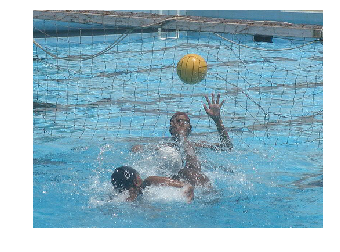

Generated caption:  two children play in a pool with a ball in a pool


In [17]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3621717946_d96f8a6012.jpg', word_to_idx, idx_to_word, max_length, False)

* *Beam search* with k = 3

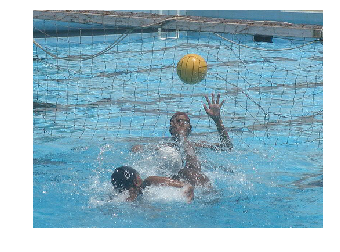

Generated caption:  two children play in a pool with a ball in a pool


In [32]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3621717946_d96f8a6012.jpg', word_to_idx, idx_to_word, max_length, True, k=3)

* *Beam search* with k = 5

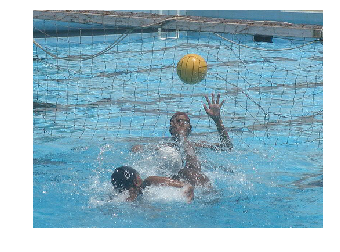

Generated caption:  two children play in a pool with a ball in the background


In [33]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3621717946_d96f8a6012.jpg', word_to_idx, idx_to_word, max_length, True, k=5)

* *Beam search* with k = 7

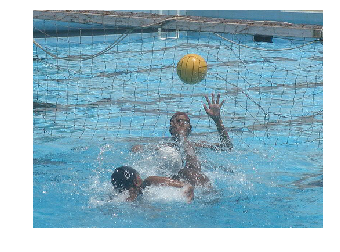

Generated caption:  two children play in a swimming pool with a ball in the background


In [34]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3621717946_d96f8a6012.jpg', word_to_idx, idx_to_word, max_length, True, k=7)

### Example 2

* *Greedy search*

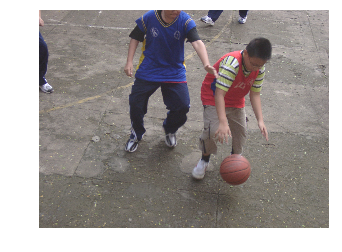

Generated caption:  a boy in a red shirt is playing with a soccer ball


In [19]:
captioning.generate_caption('datasets/test_images/02040007.JPG', word_to_idx, idx_to_word, max_length, False)

* *Beam search* with k = 3

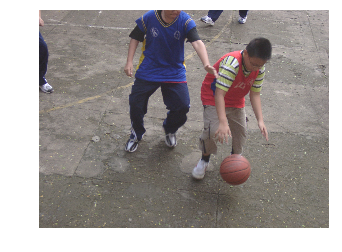

Generated caption:  a boy in a red shirt is playing with a soccer ball


In [20]:
captioning.generate_caption('datasets/test_images/02040007.JPG', word_to_idx, idx_to_word, max_length, True, k=3)

* *Beam search* with k = 5

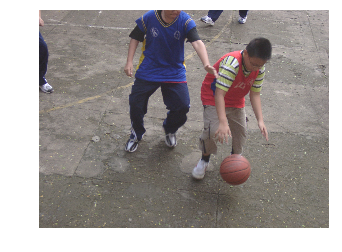

Generated caption:  two young children playing soccer on the pavement


In [21]:
captioning.generate_caption('datasets/test_images/02040007.JPG', word_to_idx, idx_to_word, max_length, True, k=5)

* *Beam search* with k = 7

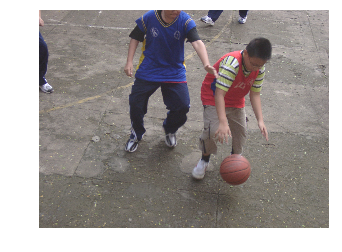

Generated caption:  a boy in a red shirt is playing with a soccer ball on the ground


In [22]:
captioning.generate_caption('datasets/test_images/02040007.JPG', word_to_idx, idx_to_word, max_length, True, k=7)

### Example 3

* *Greedy search*

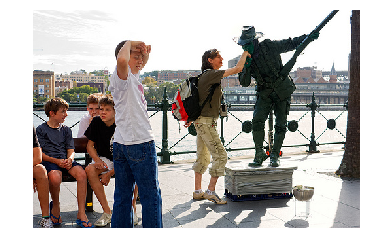

Generated caption:  a group of people are standing in front of a statue


In [26]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3482062809_3b694322c4.jpg', word_to_idx, idx_to_word, max_length, False)

* *Beam search* with k = 3

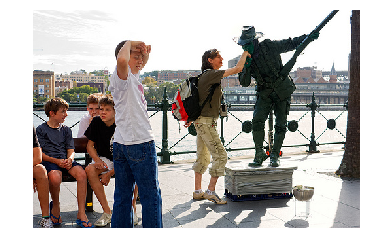

Generated caption:  a group of people are standing in front of a statue on a bench


In [27]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3482062809_3b694322c4.jpg', word_to_idx, idx_to_word, max_length, True, k=3)

* *Beam search* with k = 5

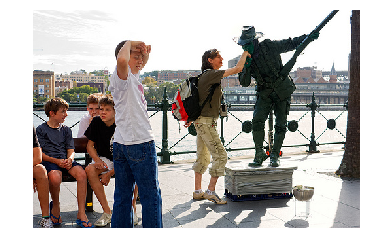

Generated caption:  a group of young men are sitting on a bench in front of a building with a man in the background


In [28]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3482062809_3b694322c4.jpg', word_to_idx, idx_to_word, max_length, True, k=5)

* *Beam search* with k = 7

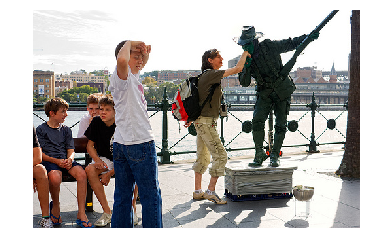

Generated caption:  a group of young men stand on a sidewalk in front of a group of people on a sunny day


In [29]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3482062809_3b694322c4.jpg', word_to_idx, idx_to_word, max_length, True, k=7)

### Example 4

* *Greedy search*

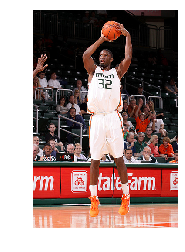

Generated caption:  a basketball player in white is trying to score to the shot


In [58]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3154641421_d1b9b8c24c.jpg', word_to_idx, idx_to_word, max_length, False)

* *Beam search* with k = 3

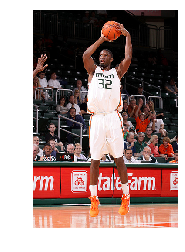

Generated caption:  a basketball player in a white uniform is trying to make a shot


In [61]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3154641421_d1b9b8c24c.jpg', word_to_idx, idx_to_word, max_length, True, k=3)

* *Beam search* with k = 5

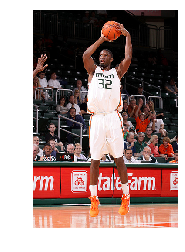

Generated caption:  a basketball player in a white uniform is trying to hit the player in the stadium


In [64]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3154641421_d1b9b8c24c.jpg', word_to_idx, idx_to_word, max_length, True, k=5)

* *Beam search* with k = 7

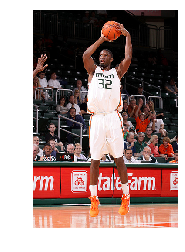

Generated caption:  a basketball player in a white uniform is trying to hit the player in the stadium


In [63]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3154641421_d1b9b8c24c.jpg', word_to_idx, idx_to_word, max_length, True, k=7)

### Example 5

* *Greedy search*

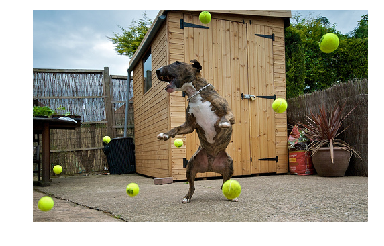

Generated caption:  a dog chases a ball with a tennis ball


In [71]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3490736665_38710f4b91.jpg', word_to_idx, idx_to_word, max_length, False)

* *Beam search* with k = 3

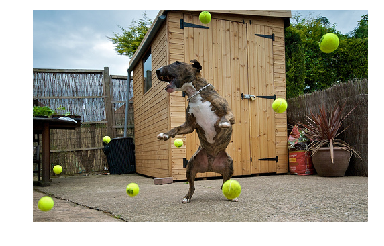

Generated caption:  a black and white dog plays with a tennis ball in the air with a tennis ball


In [72]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3490736665_38710f4b91.jpg', word_to_idx, idx_to_word, max_length, True, k=3)

* *Beam search* with k = 5

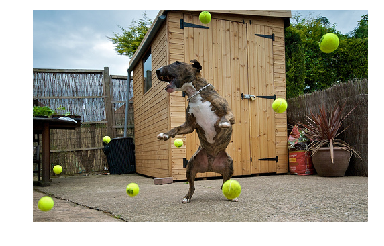

Generated caption:  a black and white dog is about to catch a tennis ball with a tennis tennis ball


In [73]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3490736665_38710f4b91.jpg', word_to_idx, idx_to_word, max_length, True, k=5)

* *Beam search* with k = 7

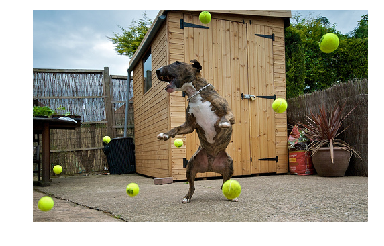

Generated caption:  a black and white dog is trying to catch a tennis ball with a tennis ball in a tennis ball


In [74]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3490736665_38710f4b91.jpg', word_to_idx, idx_to_word, max_length, True, k=7)